In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import warnings

warnings.filterwarnings("ignore")

# Start the spark context
sc = SparkContext.getOrCreate(conf=swan_spark_conf) 
print("Created Spark Context")

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()
print("Created Spark Session")

#  set good looking dataframes
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
print("Set Good Looking Dataframes")

# use Apache Arrow
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
print("Using Apache Arrow")

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import DataFrame as D

sdf = spark.read.parquet('./preprocessed_data/2018JunToAug.parquet')

# Filtering out obviously invalid rows
sdf = sdf.filter(sdf.VendorID.isin([1,2])) \
.filter(sdf.passenger_count > 0) \
.filter(sdf.trip_distance > 0) \
.filter(sdf.PULocationID.isin(list(range(1,264)))) \
.filter(sdf.DOLocationID.isin(list(range(1,264)))) \
.filter(sdf.payment_type.isin([1,2])) \
.filter(((sdf.RateCodeID == 1) & (sdf.fare_amount >= 2.5)) | ((sdf.fare_amount > 0) & (sdf.RateCodeID != 1))) \
.filter(sdf.extra >= 0) \
.filter(sdf.mta_tax >= 0) \
.filter(sdf.tip_amount >= 0) \
.filter(sdf.improvement_surcharge >= 0) \
.filter(sdf.total_amount == sdf.fare_amount + sdf.extra + sdf.mta_tax + sdf.tip_amount + sdf.improvement_surcharge) \
.filter((sdf.PUDate >= F.lit("2018-06-01")) & (sdf.PUDate <= F.lit("2018-08-31"))) \
.filter((sdf.PUDate <= sdf.DODate)) \
.filter((sdf.RateCodeID.isin([1,2,3,4,5,6])))

sdf = sdf.withColumn("is_weekend", F.dayofweek('PUDate').isin([0,6,7])).orderBy("PUDate")

sdf_weekdays = sdf.filter(sdf.is_weekend == False)
sdf_weekends = sdf.filter(sdf.is_weekend == True)

In [ ]:
#Check if there are any null values in any of the columns

names = sdf.schema.names
print("Count of Null values in each column")
for name in names:
    print(name + ': ' + str(sdf.where(sdf[name].isNull()).count()))

In [ ]:
#Check whether there are any Nan values that need to be dealt with
for n, t in sdf.dtypes:
    if (t == "int") or (t == "double"):
        sdf.select(F.count(F.when(F.isnan(n), n)).alias(n)).show()

In [ ]:
sdf_weekdays.write.format('parquet').save('./preprocessed_data/weekdaysBasicFilter.parquet')
sdf_weekends.write.format('parquet').save('./preprocessed_data/weekendsBasicFilter.parquet')

In [ ]:
sdfWeekday = spark.read.parquet('./preprocessed_data/weekdaysBasicFilter.parquet')
sdfWeekend = spark.read.parquet('./preprocessed_data/weekendsBasicFilter.parquet')

In [ ]:
from matplotlib import *

colours = {1:'r', 2:'y', 3:'b', 4:'m', 5:'g', 6:'k'}
rPatch = patches.Patch(color='r', label='RateCode1')
yPatch = patches.Patch(color='y', label='RateCode2')
bPatch = patches.Patch(color='b', label='RateCode3')
mPatch = patches.Patch(color='m', label='RateCode4')
gPatch = patches.Patch(color='g', label='RateCode5')
kPatch = patches.Patch(color='k', label='RateCode6')
legend_patches = [rPatch, yPatch, bPatch, mPatch, gPatch, kPatch]


dfDayBigTots = sdfWeekday.filter(sdfWeekday.total_amount > 100).toPandas()
dfEndBigTots = sdfWeekend.filter(sdfWeekend.total_amount > 100).toPandas()

dfDayBigFares = sdfWeekday.filter(sdfWeekday.fare_amount > 100).toPandas()
dfEndBigFares = sdfWeekend.filter(sdfWeekend.fare_amount > 100).toPandas()

def plotXvsY(df, xaxis, yaxis):
    plot = df.plot.scatter(x = xaxis, y = yaxis, c = df["RateCodeID"].map(colours))
    plot.legend(handles = legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    return plot
    
plot = plotXvsY(dfDayBigTots, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekday Totals >$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysBigTots.jpg', bbox_inches='tight')

plot = plotXvsY(dfDayBigFares, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekday Fares >$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysBigFares.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndBigTots, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekend Totals >$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsBigTots.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndBigFares, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekend Fares >$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsBigFares.jpg', bbox_inches='tight')

In [ ]:
dfDayMedTots = sdfWeekday.filter((sdfWeekday.total_amount > 50) & (sdfWeekday.total_amount <= 100)).toPandas()
dfEndMedTots = sdfWeekend.filter((sdfWeekend.total_amount > 50) & (sdfWeekend.total_amount <= 100)).toPandas()

dfDayMedFares = sdfWeekday.filter((sdfWeekday.fare_amount > 50) & (sdfWeekday.fare_amount <= 100)).toPandas()
dfEndMedFares = sdfWeekend.filter((sdfWeekend.fare_amount > 50) & (sdfWeekend.fare_amount <= 100)).toPandas()

plot = plotXvsY(dfDayMedTots, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekday Totals \$50 to \$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysMedTots.jpg', bbox_inches='tight')

plot = plotXvsY(dfDayMedFares, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekday Fares \$50 to \$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysMedFares.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndMedTots, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekend Totals \$50 to \$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsMedTots.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndMedFares, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekend Fares \$50 to \$100",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsMedFares.jpg', bbox_inches='tight')

In [ ]:
dfDaySmallTots = sdfWeekday.filter(sdfWeekday.total_amount < 3).toPandas()
dfEndSmallTots = sdfWeekend.filter(sdfWeekend.total_amount < 3).toPandas()

dfDaySmallFares = sdfWeekday.filter(sdfWeekday.fare_amount < 3).toPandas()
dfEndSmallFares = sdfWeekend.filter(sdfWeekend.fare_amount < 3).toPandas()

plot = plotXvsY(dfDaySmallTots, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekday Totals <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysSmallTots.jpg', bbox_inches='tight')

plot = plotXvsY(dfDaySmallFares, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekday Fares <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysSmallFares.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndSmallTots, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekend Totals <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsSmallTots.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndSmallFares, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekend Fares <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsSmallFares.jpg', bbox_inches='tight')

In [ ]:
#Removing some more rows now that we can see some rows that are obviously sketchy

sdf = sdf.filter(((sdf.trip_distance < 5) & (sdf.fare_amount > 60) & (sdf.RateCodeID == 1)) == False) \
.filter(((sdf.fare_amount < 2.5) & (sdf.trip_distance > 5)) == False) \
.filter(((sdf.fare_amount < 2.5) & (sdf.RateCodeID.isin([4,5]))) == False)

sdfWeekdays2 = sdf.filter(sdf.is_weekend == False)
sdfWeekends2 = sdf.filter(sdf.is_weekend == True)

In [ ]:
sdf.write.format('parquet').save('./preprocessed_data/2018JunToAugCleanedInvalids.parquet')

In [ ]:
sdfWeekdays2.write.format('parquet').save('./preprocessed_data/weekdayRemovedInvalids.parquet')
sdfWeekends2.write.format('parquet').save('./preprocessed_data/weekendsRemovedInvalids.parquet')

In [101]:
sdfWeekday2 = spark.read.parquet('./preprocessed_data/weekdayRemovedInvalids.parquet')
sdfWeekend2 = spark.read.parquet('./preprocessed_data/weekendsRemovedInvalids.parquet')

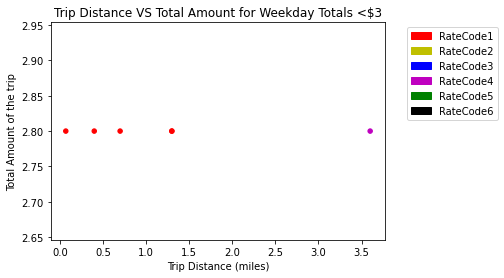

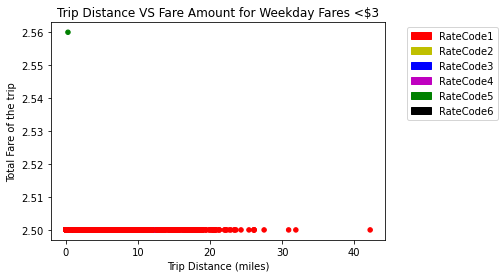

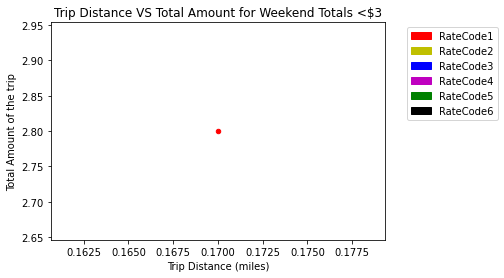

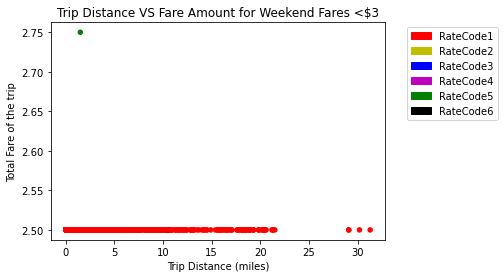

In [102]:
dfDaySmallTots2 = sdfWeekday2.filter(sdfWeekday2.total_amount < 3).toPandas()
dfEndSmallTots2 = sdfWeekend2.filter(sdfWeekend2.total_amount < 3).toPandas()

dfDaySmallFares2 = sdfWeekday2.filter(sdfWeekday2.fare_amount < 3).toPandas()
dfEndSmallFares2 = sdfWeekend2.filter(sdfWeekend2.fare_amount < 3).toPandas()

plot = plotXvsY(dfDaySmallTots2, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekday Totals <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysSmallTots2.jpg', bbox_inches='tight')

plot = plotXvsY(dfDaySmallFares2, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekday Fares <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekdaysSmallFares2.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndSmallTots2, "trip_distance", "total_amount")
plot.set(title = "Trip Distance VS Total Amount for Weekend Totals <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Amount of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsSmallTots2.jpg', bbox_inches='tight')

plot = plotXvsY(dfEndSmallFares2, "trip_distance", "fare_amount")
plot.set(title = "Trip Distance VS Fare Amount for Weekend Fares <$3",
         xlabel = "Trip Distance (miles)",
         ylabel = "Total Fare of the trip")
figure = plot.get_figure()
figure.savefig('./plots/WeekendsSmallFares2.jpg', bbox_inches='tight')